In this notebook we give a quick intro to implementing Markov Chain Monte Carlo (MCMC) methods using tf probability. We choose a simple Bernoulli coin toss problem (for which the conjugate prior is known) so that we can verify our MCMC results analytically. 

#### Problem Outline

Let's look at the following problem: We have a biased coin that gives us "Heads" with probability $\theta$. Surely $ \theta \in [0, 1] $, but beyond that we don't know much and adopt a Bayesian viewpoint, that is we want to treat $\theta$ as a random variable and describe it in terms of a distribution. Reflecting no particular view initially, we choose a uniform prior  
$$ \theta \sim U[0, 1], $$


As we now throw the coin, we obtain new data that we use to update our priors according to Bayes' rule:

$$ p(\theta | Data) = \frac{p(Data | \theta) \ p(\theta)}{p(Data)} \propto p(Data | \theta) \ p(\theta)$$

where p($\theta$) is our uniform prior. We thus have a standard Bayesian setup that lends itself to the application of MCMC to sample from the posterior $p(\theta | Data)$.


#### MCMC aproach

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import seaborn as sns


In [7]:


# build the posterior distribution (up to normalization constant) as a JointDistributionSequential object:
def build_posterior(n_throws):
    posterior = tfd.JointDistributionSequential([
        # prior distribution for theta; the lambda specifies theta is input for Binomial distribution:
        tfd.Uniform(low=[0.0], high=[1.0]), lambda theta:
        # likelihood of the data conditional on theta:
        tfd.Independent(tfd.Binomial(total_count=n_throws, probs=theta), reinterpreted_batch_ndims=1)
    ])
    return posterior


In [8]:
## Specify the evidence:

# We assume we get seven Heads on 10 throws:
data = [7.]
n_throws = [10.]
posterior = build_posterior(n_throws)

# specify number of steps of the MCMC chain and burn-in steps:
num_steps, num_burnin_steps = 20000, 5000

# a function returning the log prob of our posterior:
def post_log_prob(theta):
    return tf.reshape(posterior.log_prob(([theta], data)), [])

In [9]:
# Specify the MCMC setup.

# tfp.mcmc.sample_chain: standard setup to build MCMC chain based on Transition Kernel that is specified as kernel argument

@tf.function(autograph=False)
def run_mcmc():
  return tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=num_burnin_steps,
      current_state=[tf.constant([0.5])],
      kernel=adaptive_kernel)


# tfp.mcmc.HamiltonianMonteCarlo: runs one step of Hamiltonian MC
# target_log_prob_fn is the log prob evaluation for the Metropolis accept step
# step_size is leapfrog integrator setp size; num_leapfrog_steps is number of steps to run leapfrog integrator for (chosen typical values)
hmc_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=post_log_prob,
          step_size=0.4,
          num_leapfrog_steps=2)

# using SimpleStepSizeAdaptaition as a TransitionKernel for the MCMC. This adapts kernel's step size based on log_accept_prob.
# we set a target acceptance probability, good values depend on the Kernel, for hamiltonian MC good value is between 0.6-0.9
# number of adaptation steps should be set somewhat smaller than number of burn-in steps, as after adaptation phase we need
# some more warm up until we sample from the correct distribution (we might be in tails of distribution at end of adaptation for example) 
adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
  hmc_kernel,
  num_adaptation_steps=int(.8 * num_burnin_steps),
  target_accept_prob=np.float32(.65))

In [10]:
## run MCMC:

states, kernel_results = run_mcmc()

c:\users\hendrik\desktop\hk\programming\python\pyenvs\py38\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:341: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


c:\users\hendrik\desktop\hk\programming\python\pyenvs\py38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

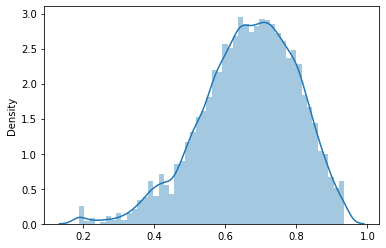

In [12]:
sns.distplot(states)

In [13]:
## the expectation for our probability theta is:
print("Expectation for theta: ",np.average(states[0]))

Expectation for theta:  0.6665856


#### Cross checking the result:


With $ p(\theta) $ our uniform prior (so just a constant) and requiring that the density integrates to 1 we see that the conditional posterior is just beta distributed (beta distribution is the conjugate prior of Binomial distribution):

$$p(\theta | Data) = \frac{p(Data | \theta) \ p(\theta)}{p(Data)} = \frac{{n\choose k} \ \theta^k \ (1-\theta)^{n-k}}{p(Data)} = \frac{\theta^k \ (1-\theta)^{n-k}}{\int_0^1 p(Data | \theta)\ p(\theta) d\theta} = \frac{\theta^k \ (1-\theta)^{n-k}}{\int_0^1 \theta^k \ (1-\theta)^{n-k} d\theta} = Beta(k+1, n-k+1)$$

For $X \sim Beta(\alpha, \beta)$ we have:

$$ \mathbb{E}[X] = \frac{\alpha}{\alpha + \beta} = \frac{k+1}{n+2}$$

In our example above we chose $n = 10$ and $k=7$, giving $ \mathbb{E}[\theta] = \frac{2}{3}$, in good agreement with the simulation result above.